Libraries & Parameters

In [1]:
!pip install -q awswrangler

import awswrangler as wr
import pandas as pd

import boto3
import pytz

import numpy as np
!pip install -U -q seaborn
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from sagemaker import get_execution_role

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
# Get Sagemaker Role
role = get_execution_role()
print(role)

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210503T205912 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


arn:aws:iam::506926764659:role/service-role/AmazonSageMaker-ExecutionRole-20210503T205912


Runtime Parameters

In [3]:
# airline_to_run = 'MQ'

___
# 1.) Download Data

## S3 parameters

In [4]:
# Flight data from Sagemaker Data Wrangler
bucket = 'sagemaker-us-west-2-506926764659/export-flow-05-16-30-08-0c003aed/output/data-wrangler-flow-processing-05-16-30-08-0c003aed/b98f4f8c-ddaf-4ee1-99da-b0dd09f47a21/default'
filename = 'part-00000-92fade68-00c4-41b3-9182-593084da2eae-c000.csv'
path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from entire year of 2011
# bucket = 'from-public-data/carrier-perf/transformed'
# filename = 'airOT2011all.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from 2011_01 
# bucket = 'from-public-data/carrier-perf/transformed/airOT2011'
# filename = 'airOT201101.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)


# ________________________________________________________________
# Supporting dataset useful for EDA and understanding data
#   - airport codes
#   - airline codes
bucket2 = 'from-public-data/carrier-perf/raw'
file_airport = 'airports.csv'
file_airline = 'airlines.csv'

path_to_file_airport = 's3://{}/{}'.format(bucket2, file_airport)
path_to_file_airline = 's3://{}/{}'.format(bucket2, file_airline)

=== === === === ===
## Download data from S3

### 1. Flights Performance dataset

In [5]:
df = wr.s3.read_csv([path_to_file])
# df

A whopping 7,294,649 rows (records) of JUST year 2007!  Thanks to all the Sagemaker Data Wrangler, I was able to already do some data cleaning and adjustment:
  - Create new variable `late_flight` depending on `DEP_DELAY`
  - Trim value to remove outliers for `DEP_DLAY`
  - Drop records for Cancelled flights `CANCELED` == 1 (doesn't make much sense to have flights that's irrelevant to flights delay when flight never occur)

### 2. Airports & Airlines dataset

In [6]:
df_airports = wr.s3.read_csv([path_to_file_airport])
df_airlines = wr.s3.read_csv([path_to_file_airline])
# df_airlines

=== === === === ===
## Initial Data Clean-up and Organization

In [7]:
# rename 'DAY_OF_MONTH' column to 'DAY' (in prep of transforming to datetime format)
df = df.rename(columns={'DAY_OF_MONTH': 'DAY'})
# df

### 1. Date / Time modifications

Make date and time more appropriate.  This will make it easier when making plots.

In [8]:
# Create a datetime field `DATE`
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

In [9]:
# Convert 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

In [10]:
df['DEP_TIME'] = df['DEP_TIME'].apply(format_heure)
df['ARR_TIME'] = df['ARR_TIME'].apply(format_heure)

### 2. Organize Columns

Let's organize columns (features) to be more logical

In [11]:
variables_to_remove = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']
df.drop(variables_to_remove, axis = 1, inplace = True)

df = df[[
    'DATE',
    'YEAR',
    'MONTH',
    'DAY',
    'DAY_OF_WEEK',
    'UNIQUE_CARRIER',
    'ORIGIN',
    'DEST',
    'DEP_TIME',
    'DEP_DELAY',
    'DEP_DELAY_no_outlier',
    'ACTUAL_ELAPSED_TIME',
    'AIR_TIME',
    'DISTANCE',
    'ARR_TIME',
    'ARR_DELAY',
    'CARRIER_DELAY',
    'WEATHER_DELAY',
    'NAS_DELAY',
    'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'late_flight']]

In [12]:
# REMOVED for a generalized ML model for all airline carriers
# df_toTrain = df.loc[df['UNIQUE_CARRIER'] == airline_to_run]
df_toTrain = df

distinct_airlines = df_toTrain.UNIQUE_CARRIER.unique()
print('New dataset has {0} records with {1} variables, containing only airlines {2}'.format(df_toTrain.shape[0], df_toTrain.shape[1], distinct_airlines))

New dataset has 7294649 records with 22 variables, containing only airlines ['9E' 'AA' 'KH' 'AS' 'B6' 'CO' 'DL' 'EV' 'F9' 'FL' 'HA' 'MQ' 'NW' 'OH'
 'OO' 'UA' 'US' 'WN' 'XE' 'YV']


In [13]:
df_toTrain

,DATE,YEAR,MONTH,DAY,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,...,AIR_TIME,DISTANCE,ARR_TIME,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,late_flight
0,2007-01-01,2007,1,1,1,9E,DCA,GRR,20:44:00,44.0,...,95.0,524.0,23:02:00,70.0,0.0,0.0,26.0,0.0,44.0,late
1,2007-01-01,2007,1,1,1,9E,MSP,CID,19:39:00,7.0,...,39.0,221.0,21:51:00,75.0,7.0,0.0,68.0,0.0,0.0,late
2,2007-01-01,2007,1,1,1,9E,MSP,FAR,09:13:00,-2.0,...,39.0,223.0,10:09:00,-19.0,NaN,NaN,NaN,NaN,NaN,late
3,2007-01-01,2007,1,1,1,9E,MSP,AZO,21:22:00,57.0,...,55.0,426.0,23:50:00,53.0,53.0,0.0,0.0,0.0,0.0,late
4,2007-01-01,2007,1,1,1,9E,MSP,DFW,14:10:00,10.0,...,123.0,852.0,16:28:00,-7.0,NaN,NaN,NaN,NaN,NaN,late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7294644,2007-12-31,2007,12,31,1,YV,YUM,PHX,07:50:00,-10.0,...,38.0,160.0,08:55:00,-12.0,NaN,NaN,NaN,NaN,NaN,late
7294645,2007-12-31,2007,12,31,1,YV,YUM,PHX,12:20:00,-14.0,...,33.0,160.0,13:14:00,-12.0,NaN,NaN,NaN,NaN,NaN,late
7294646,2007-12-31,2007,12,31,1,YV,YUM,PHX,16:00:00,-5.0,...,33.0,160.0,16:58:00,-2.0,NaN,NaN,NaN,NaN,NaN,late
7294647,2007-12-31,2007,12,31,1,YV,YUM,PHX,09:00:00,-30.0,...,31.0,160.0,10:14:00,-10.0,NaN,NaN,NaN,NaN,NaN,late


___
# 2.) Explorational Data Analysis

## Distribution of Target (dependent) Variable `late_flight`

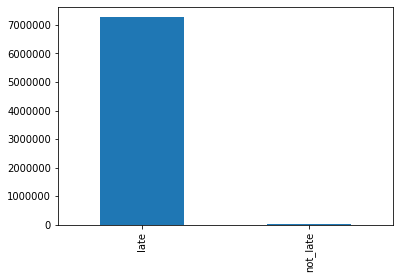

In [14]:
df_toTrain.late_flight.value_counts().plot(kind='bar')

In [15]:
df_toTrain.late_flight.value_counts()

late        7263230
not_late      31419
Name: late_flight, dtype: int64

**NOTE** Looks like a pretty imbalance distribution of target variable.  Will probably need to use SMOTE and create synthetic data for the minority class.

## Corrleations

Text(0.5, 1, 'Correlation Heatmap')

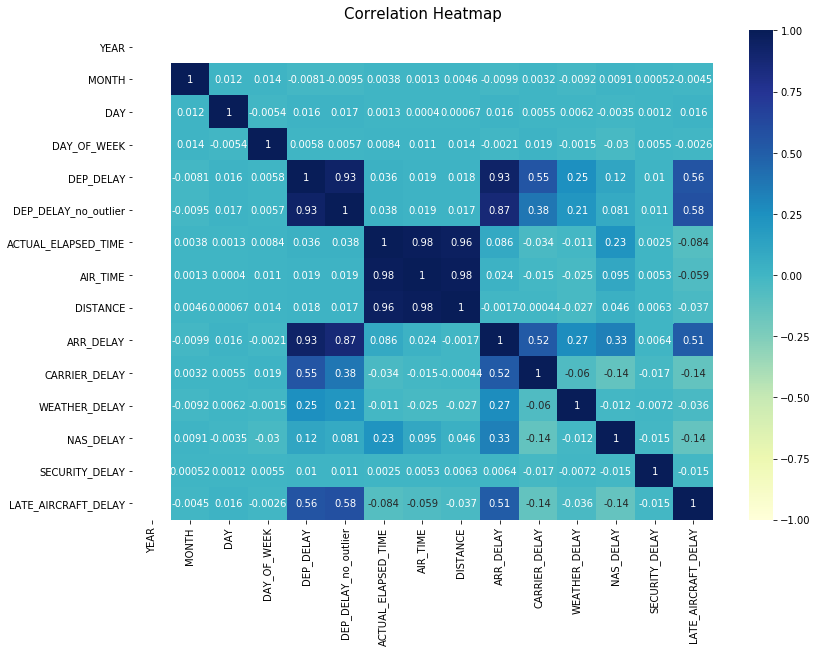

In [16]:
# increase figure size
plt.figure(figsize=(13, 9))
heatmap = sns.heatmap(df_toTrain.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu")

# define title
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':15}, pad=12)

# ref. https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

**NOTE** Looks like high correlation between:
  - `DEP_DELAY_no_outlier` :: `ARR_DELAY`, which could makes logical sense because if you are late departing, then you are likely to be late arriving
  - `ACTUAL_ELAPSED_TIME` :: `DISTANCE` :: `AIR_TIME`, which make sense as each 3-variables are referencing same part of flight

# 3.) Train Model

In [17]:
# Download PyCaret
!pip install pycaret --quiet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


## a. Get the Data

In [18]:
data = df_toTrain.sample(frac=0.01, random_state=123)
data_unseen = df.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (72946, 22)
Unseen Data For Predictions: (7221703, 22)


## b. Setting Up Environment in PyCaret

In [19]:
from pycaret.classification import *
exp = setup(data = data, 
            numeric_features = ['YEAR', 'MONTH','DAY','DAY_OF_WEEK'],
            ignore_features = ['DEP_DELAY', 'ARR_DELAY', 'AIR_TIME', 'ACTUAL_ELAPSED_TIME', 'ARR_TIME'],
            target = 'late_flight',
            fix_imbalance = True,
            normalize = True,
            transformation = True,
            ignore_low_variance = True,
            remove_multicollinearity = True,
            multicollinearity_threshold = 0.95,
            use_gpu = True,
            fold = 2
           )

,Description,Value
0,session_id,3505
1,Target,late_flight
2,Target Type,Binary
3,Label Encoded,"late: 0, not_late: 1"
4,Original Data,"(72946, 22)"
5,Missing Values,True
6,Numeric Features,11
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


## c. Comparing all models

In [20]:
# ref. 
#   -- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=compare_models#pycaret.classification.compare_models
#   -- https://machinelearningmastery.com/k-fold-cross-validation/

best_model = compare_models(cross_validation=False)
# best_model = compare_modelfold=old=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9959,0.9224,0.0000,0.0000,0.0000,-0.0001,-0.0004,27.9800
et,Extra Trees Classifier,0.9957,0.7415,0.0000,0.0000,0.0000,-0.0006,-0.0011,38.6200
lightgbm,Light Gradient Boosting Machine,0.9941,0.9676,0.0114,0.0233,0.0153,0.0127,0.0135,7.0300
dt,Decision Tree Classifier,0.9912,0.5372,0.0795,0.0593,0.0680,0.0636,0.0643,50.4800
qda,Quadratic Discriminant Analysis,0.9834,0.6069,0.2273,0.0635,0.0993,0.0936,0.1136,13.6500
knn,K Neighbors Classifier,0.9574,0.5904,0.1250,0.0127,0.0230,0.0159,0.0278,15.7300
ada,Ada Boost Classifier,0.9455,0.9689,0.8068,0.0570,0.1064,0.0997,0.2056,21.0300
gbc,Gradient Boosting Classifier,0.9439,0.9683,0.7614,0.0526,0.0985,0.0916,0.1909,114.9400
nb,Naive Bayes,0.9432,0.8696,0.7955,0.0540,0.1012,0.0943,0.1982,1.5500
lr,Logistic Regression,0.8791,0.7650,0.4545,0.0152,0.0294,0.0217,0.0652,24.4700


# 4.) Create Model(s)

## a. Random Forest Classifier

In [21]:
rf = create_model('rf')
# rf = create_model('rf', cross_validation=False)

# trained model object is stored as `rf`
# print(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9952,0.9155,0.0000,0.0000,0.0000,-0.0001,-0.0004
1,0.9951,0.9204,0.0000,0.0000,0.0000,-0.0002,-0.0006
Mean,0.9952,0.9179,0.0000,0.0000,0.0000,-0.0001,-0.0005
SD,0.0000,0.0025,0.0000,0.0000,0.0000,0.0000,0.0001


## b. Ada Boost Classifier

In [22]:
ada = create_model('ada')
# ada = create_model('ada', cross_validation=False)

# trained model object is stored as `ada`
# print(ada)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9573,0.9677,0.6885,0.0739,0.1334,0.1259,0.2163
1,0.9548,0.9665,0.6803,0.0693,0.1258,0.1181,0.2075
Mean,0.9560,0.9671,0.6844,0.0716,0.1296,0.1220,0.2119
SD,0.0012,0.0006,0.0041,0.0023,0.0038,0.0039,0.0044


## c. Light Gradient Boosting Machine

In [23]:
lightgbm = create_model('lightgbm')
# lightgbm = create_model('lightgbm', cross_validation=False)

# trained model object is stored as `lightgbm`
# print(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9944,0.9689,0.0410,0.1613,0.0654,0.0635,0.0791
1,0.9942,0.9670,0.0164,0.0645,0.0261,0.0243,0.0302
Mean,0.9943,0.9679,0.0287,0.1129,0.0458,0.0439,0.0547
SD,0.0001,0.0010,0.0123,0.0484,0.0196,0.0196,0.0245


# 5.) Tune Model(s)

## c. Light Gradient Boosting Machine

In [24]:
tuned_lightgbm = tune_model(lightgbm, n_iter=2, early_stopping=True)

# tuned model object is stored as `tuned_lightgbm`
# print(tuned_lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9846,0.9679,0.2213,0.0831,0.1208,0.1147,0.1289
1,0.9830,0.9675,0.1557,0.0543,0.0805,0.0739,0.0846
Mean,0.9838,0.9677,0.1885,0.0687,0.1007,0.0943,0.1068
SD,0.0008,0.0002,0.0328,0.0144,0.0201,0.0204,0.0221


# 6.) Models Performance

## c. Light Gradient Boosting Machine

### i. Confusion Matrix

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


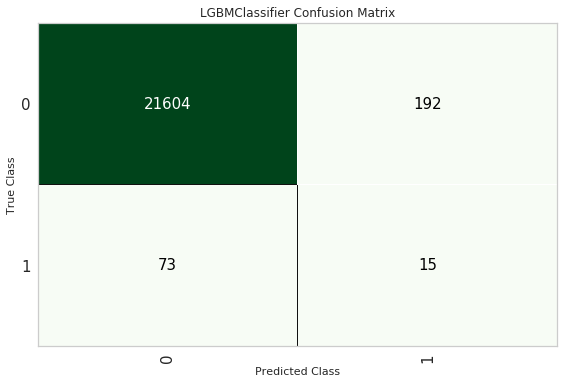

In [25]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

### ii. Features Importance

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


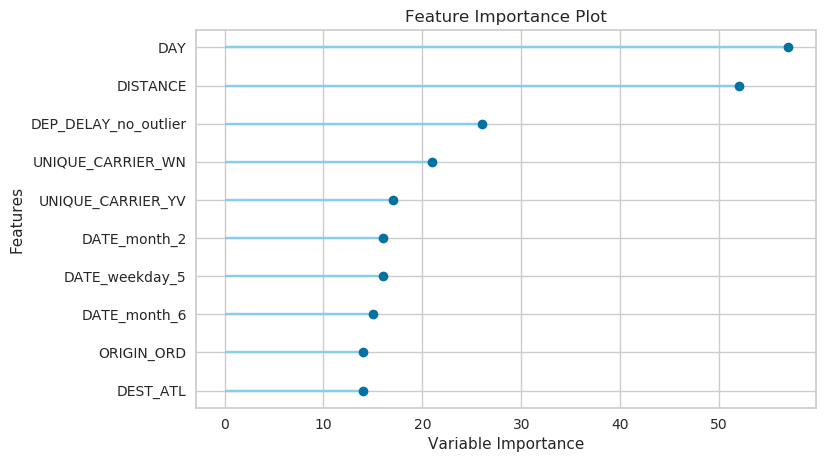

In [26]:
plot_model(tuned_lightgbm, plot='feature')

Features that has greatest explanatory power are:

* `DISTANCE`
* `DAY` of the month
* (closely by) `MONTH`

### iii. Intrepret Model's with SHAP

ref. 

* https://www.analyticsvidhya.com/blog/2020/05/pycaret-machine-learning-model-seconds/
* https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/?utm_source=blog&utm_medium=pycaret-machine-learning-model-seconds

In [27]:
!apt-get update && apt-get install -y build-essential -q
!python -m pip install -q shap

Get:1 http://deb.debian.org/debian buster InRelease [121 kB]
Get:2 http://security.debian.org/debian-security buster/updates InRelease [65.4 kB]
Get:3 http://deb.debian.org/debian buster-updates InRelease [51.9 kB]
Get:4 http://deb.debian.org/debian buster/main amd64 Packages [7907 kB]
Get:5 http://deb.debian.org/debian buster-updates/main amd64 Packages [10.9 kB]
Get:6 http://security.debian.org/debian-security buster/updates/main amd64 Packages [285 kB]
Fetched 8441 kB in 3s (2981 kB/s)                        
Reading package lists... Done
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-8 dirmngr
  dpkg-dev fakeroot g++ g++-8 gcc gcc-8 gnupg gnupg-l10n gnupg-utils gpg
  gpg-agent gpg-wks-client gpg-wks-server gpgconf gpgsm libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libassuan0
  libatomic1 libbinuti

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


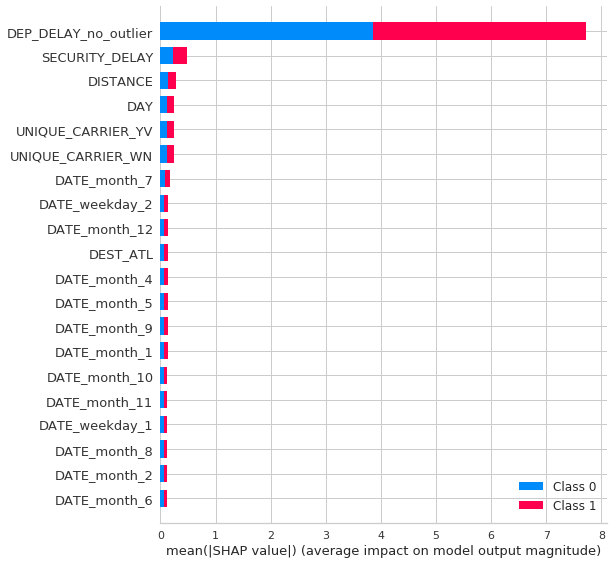

In [28]:
interpret_model(tuned_lightgbm, plot='summary')

In [ ]:
interpret_model(tuned_lightgbm, plot='correlation')

# 8.) Predict of Test Data Sample

## c. Light Gradient Boosting Machine

In [29]:
predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9879,0.9674,0.1705,0.0725,0.1017,0.0966,0.1057


,DAY,DAY_OF_WEEK,DEP_DELAY_no_outlier,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,UNIQUE_CARRIER_9E,...,DATE_weekday_1,DATE_weekday_2,DATE_weekday_4,DATE_weekday_5,DATE_weekday_6,DATE_is_month_end_1,DATE_is_month_start_0,late_flight,Label,Score
0,-0.993852,1.515068,0.914528,-0.653296,0.141132,-1.686735,-2.086099,-1.683787,-2.105399,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,late,late,0.9984
1,0.257586,-0.460955,-0.686167,1.300045,0.262232,0.449962,0.226436,0.540754,0.233441,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,late,late,0.9990
2,0.712084,1.515068,0.369271,-0.780946,0.262232,0.449962,0.226436,0.540754,0.233441,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,late,late,0.9981
3,-0.880004,0.540942,-0.966461,-0.527201,0.262232,0.449962,0.226436,0.540754,0.233441,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,late,late,0.9988
4,-0.197221,-1.492096,-0.198222,2.118306,0.262232,0.449962,0.226436,0.540754,0.233441,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,late,late,0.8240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21879,0.143918,1.030531,1.621416,0.528776,-0.891523,-1.686735,-0.373266,-1.683787,1.209240,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,late,late,0.9986
21880,-1.107712,-0.973772,1.866820,0.593633,-2.094512,-1.686735,-1.327676,-1.683787,2.393533,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,late,late,0.9982
21881,-1.221584,-1.492096,-1.116191,-1.252364,0.262232,0.449962,0.226436,0.540754,0.233441,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,late,late,0.9988
21882,0.257586,1.515068,1.656837,-0.198488,-2.094512,3.960206,0.137675,-1.683787,-2.105399,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,late,late,0.9981


# 9.) Deploy Model (finalized)

## c. Light Gradient Boosting Machine

In [30]:
final_lightgbm = finalize_model(tuned_lightgbm)

#Final model's parameters for deployment
print(final_lightgbm)

[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
LGBMClassifier(bagging_fraction=0.4, bagging_freq=5, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
               importance_type='split', learning_rate=0.5, max_depth=-1,
               min_child_samples=31, min_child_weight=0.001, min_split_gain=

**Caution**: Once the model is finalized using `finalize_model()`, the entire dataset including the test/hold-out set is used for training. As a result, if the model is used for predictions on the hold-out set after `finalize_model()` is used, the information grid printed will be misleading as you are trying to predict on the same data that was used for modeling.

In [31]:
predict_model(final_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9919,0.9879,0.5000,0.2486,0.3321,0.3285,0.3490


,DAY,DAY_OF_WEEK,DEP_DELAY_no_outlier,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,UNIQUE_CARRIER_9E,...,DATE_weekday_1,DATE_weekday_2,DATE_weekday_4,DATE_weekday_5,DATE_weekday_6,DATE_is_month_end_1,DATE_is_month_start_0,late_flight,Label,Score
0,-0.993852,1.515068,0.914528,-0.653296,0.141132,-1.686735,-2.086099,-1.683787,-2.105399,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,late,late,0.9992
1,0.257586,-0.460955,-0.686167,1.300045,0.262232,0.449962,0.226436,0.540754,0.233441,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,late,late,0.9988
2,0.712084,1.515068,0.369271,-0.780946,0.262232,0.449962,0.226436,0.540754,0.233441,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,late,late,0.9991
3,-0.880004,0.540942,-0.966461,-0.527201,0.262232,0.449962,0.226436,0.540754,0.233441,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,late,late,0.9993
4,-0.197221,-1.492096,-0.198222,2.118306,0.262232,0.449962,0.226436,0.540754,0.233441,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,late,late,0.9127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21879,0.143918,1.030531,1.621416,0.528776,-0.891523,-1.686735,-0.373266,-1.683787,1.209240,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,late,late,0.9990
21880,-1.107712,-0.973772,1.866820,0.593633,-2.094512,-1.686735,-1.327676,-1.683787,2.393533,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,late,late,0.9988
21881,-1.221584,-1.492096,-1.116191,-1.252364,0.262232,0.449962,0.226436,0.540754,0.233441,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,late,late,0.9993
21882,0.257586,1.515068,1.656837,-0.198488,-2.094512,3.960206,0.137675,-1.683787,-2.105399,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,late,late,0.9992


# 10.) Predict on Unseen Dataset

In [41]:
# Decrease size of unseen data `data_unseen` by sampling 168 random rows
data_unseen_mini = data_unseen.sample(n = 168)

unseen_predictions = predict_model(final_lightgbm, data=data_unseen_mini)
unseen_predictions

,DATE,YEAR,MONTH,DAY,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,...,ARR_TIME,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,late_flight,Label,Score
6197289,2007-11-23,2007,11,23,5,DL,GPT,ATL,16:46:00,-10.0,...,18:49:00,-29.0,NaN,NaN,NaN,NaN,NaN,late,late,0.9990
1859500,2007-04-25,2007,4,25,3,CO,EWR,PBI,08:08:00,-2.0,...,11:17:00,-4.0,NaN,NaN,NaN,NaN,NaN,late,late,0.9989
5961336,2007-10-25,2007,10,25,4,WN,TPA,PHX,15:24:00,29.0,...,16:32:00,12.0,NaN,NaN,NaN,NaN,NaN,late,late,0.9994
1649331,2007-03-18,2007,3,18,7,WN,RNO,OAK,07:12:00,2.0,...,08:10:00,5.0,NaN,NaN,NaN,NaN,NaN,late,late,0.9990
3174128,2007-06-09,2007,6,9,6,FL,ATL,HOU,15:55:00,1.0,...,16:48:00,-18.0,NaN,NaN,NaN,NaN,NaN,late,late,0.9994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6671400,2007-12-29,2007,12,29,6,AA,DFW,MSY,13:29:00,24.0,...,14:43:00,13.0,NaN,NaN,NaN,NaN,NaN,late,late,0.9990
2115550,2007-04-30,2007,4,30,1,OO,LAX,FAT,18:49:00,-1.0,...,19:56:00,1.0,NaN,NaN,NaN,NaN,NaN,late,late,0.9993
2281659,2007-04-28,2007,4,28,6,WN,AUS,LBB,17:22:00,-3.0,...,18:25:00,-10.0,NaN,NaN,NaN,NaN,NaN,late,late,0.9989
1089975,2007-02-07,2007,2,7,3,XE,EWR,DTW,06:44:00,-1.0,...,09:07:00,19.0,0.0,0.0,19.0,0.0,0.0,late,late,0.9993


In [44]:
KPI = 'Accuracy'
from pycaret.utils import check_metric
# check_metric(unseen_predictions['late_flight'], unseen_predictions['Label'])
KPI_score = check_metric(unseen_predictions['late_flight'], unseen_predictions['Label'], metric=KPI)


print('The {0} of `lightgbm` model is {1}.'.format(KPI, KPI_score))

The Accuracy of `lightgbm` model is 0.994.


# 11.) Persist Model

In [45]:
today = datetime.datetime.now()
today_datetime = today.strftime("%d-%m-%Y %H:%M:%S")
pkl_filename = 'Final_model___' + 'lightgbm' + '___for_all_airlines_' + today_datetime

save_model(final_lightgbm, pkl_filename)

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['DEP_DELAY', 'ARR_DELAY',
                                                        'AIR_TIME',
                                                        'ACTUAL_ELAPSED_TIME',
                                                        'ARR_TIME'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['YEAR', 'MONTH',
                                                           'DAY',
                                                           'DAY_OF_WEEK'],
                                       target='late_flight', time_features=[])),
                 ('imputer',
                  Simple_Impute...
                                 boosting_ty

# 12.) Load a Saved Model

In [47]:
# REMEMBER to omit file suffix ".pkl"
model_to_load = 'Final_model___lightgbm___for_all_airlines_07-05-2021 13:31:37'

saved_model = load_model(model_to_load)

Transformation Pipeline and Model Successfully Loaded


In [49]:
# Decrease size of unseen data `data_unseen` by sampling 168 random rows
data_unseen_mini = data_unseen.sample(n = 168)

new_prediction = predict_model(saved_model, data=data_unseen_mini)
new_prediction.head()

,DATE,YEAR,MONTH,DAY,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,...,ARR_TIME,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,late_flight,Label,Score
4342282,2007-08-04,2007,8,4,6,DL,ATL,BOS,13:30:00,0.0,...,16:04:00,0.0,NaN,NaN,NaN,NaN,NaN,not_late,late,0.8939
1901186,2007-04-16,2007,4,16,1,DL,MSY,ATL,18:48:00,-4.0,...,21:06:00,-10.0,NaN,NaN,NaN,NaN,NaN,late,late,0.9992
2332398,2007-04-11,2007,4,11,3,YV,KOA,HNL,10:15:00,-15.0,...,11:00:00,-10.0,NaN,NaN,NaN,NaN,NaN,late,late,0.9994
7020143,2007-12-26,2007,12,26,3,UA,ORD,DEN,18:54:00,129.0,...,20:34:00,126.0,43.0,0.0,0.0,0.0,83.0,late,late,0.9990
530465,2007-01-28,2007,1,28,7,WN,PHL,PVD,16:04:00,-1.0,...,17:06:00,-9.0,NaN,NaN,NaN,NaN,NaN,late,late,0.9991


In [50]:
KPI = 'Accuracy'
from pycaret.utils import check_metric
# check_metric(unseen_predictions['late_flight'], unseen_predictions['Label'])
KPI_score = check_metric(new_prediction['late_flight'], new_prediction['Label'], metric=KPI)


print('The {0} of `lightgbm` model is {1}.'.format(KPI, KPI_score))

The Accuracy of `lightgbm` model is 0.9821.
